<a href="https://colab.research.google.com/github/valentinptr/pytorch_learning/blob/main/01_pytorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

In [2]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [3]:
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [5]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

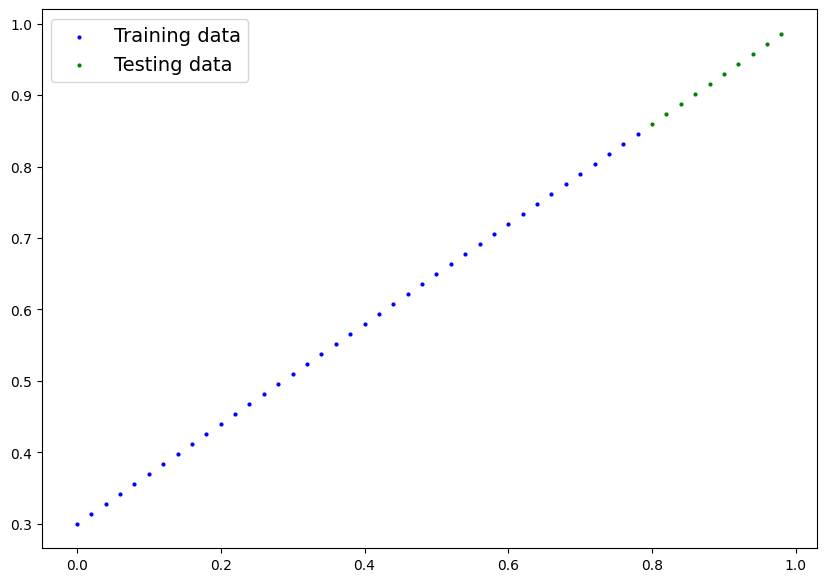

In [5]:
plot_predictions()

In [6]:
# Create a Linear Regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
                                                dtype=torch.float), # <- PyTorch loves float32 by default
                                   requires_grad=True) # <- can we update this value with gradient descent?)

        self.bias = nn.Parameter(torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
                                            dtype=torch.float), # <- PyTorch loves float32 by default
                                requires_grad=True) # <- can we update this value with gradient descent?))

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)

In [41]:
# Set manual seed since nn.Parameter are randomly initialized
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = LinearRegressionModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [42]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [9]:
# Make predictions with model
with torch.inference_mode():
    y_preds = model_0(X_test)

In [10]:
# Check the predictions
print(f"Number of testing samples: {len(X_test)}")
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


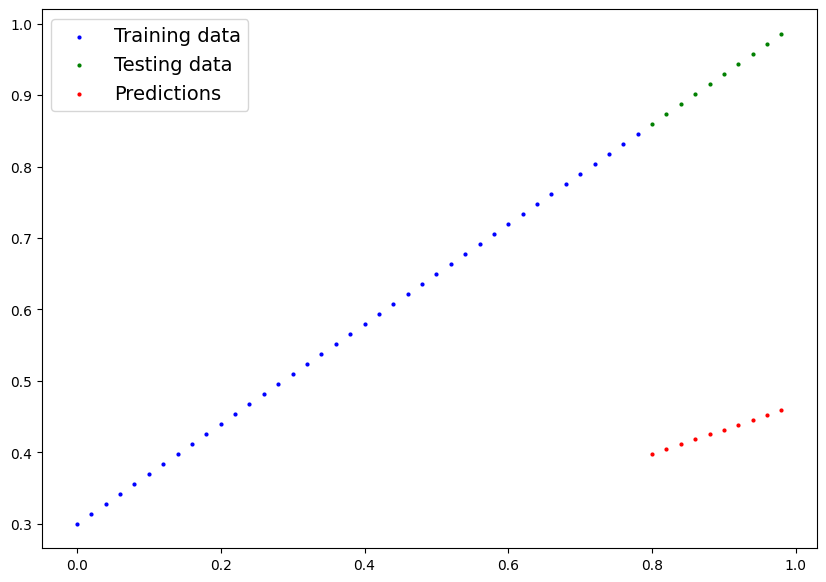

In [30]:
plot_predictions(predictions=y_preds)

In [43]:
torch.manual_seed(42)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 170

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

# Create the loss function
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss

# Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), # parameters of target model to optimize
                            lr=0.01) # learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time))

for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model)
    model_0.train()

    # 1. Forward pass on train data using the forward() method inside
    y_pred = model_0(X_train)
    # print(y_pred)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    ### Testing

    # Put the model in evaluation mode
    model_0.eval()

    with torch.inference_mode():
      # 1. Forward pass on test data
      test_pred = model_0(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

      # Print out what's happening
      if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.31288138031959534 | MAE Test Loss: 0.48106518387794495 
Epoch: 10 | MAE Train Loss: 0.1976713240146637 | MAE Test Loss: 0.3463551998138428 
Epoch: 20 | MAE Train Loss: 0.08908725529909134 | MAE Test Loss: 0.21729660034179688 
Epoch: 30 | MAE Train Loss: 0.053148526698350906 | MAE Test Loss: 0.14464017748832703 
Epoch: 40 | MAE Train Loss: 0.04543796554207802 | MAE Test Loss: 0.11360953003168106 
Epoch: 50 | MAE Train Loss: 0.04167863354086876 | MAE Test Loss: 0.09919948130846024 
Epoch: 60 | MAE Train Loss: 0.03818932920694351 | MAE Test Loss: 0.08886633068323135 
Epoch: 70 | MAE Train Loss: 0.03476089984178543 | MAE Test Loss: 0.0805937647819519 
Epoch: 80 | MAE Train Loss: 0.03132382780313492 | MAE Test Loss: 0.07232122868299484 
Epoch: 90 | MAE Train Loss: 0.02788739837706089 | MAE Test Loss: 0.06473556160926819 
Epoch: 100 | MAE Train Loss: 0.024458957836031914 | MAE Test Loss: 0.05646304413676262 
Epoch: 110 | MAE Train Loss: 0.021020207554101944 | MAE

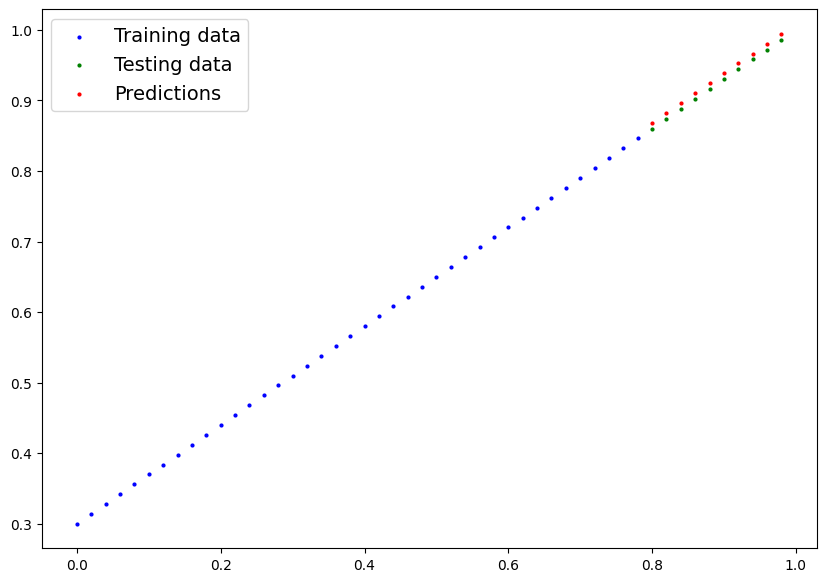

In [44]:
plot_predictions(predictions=test_pred)

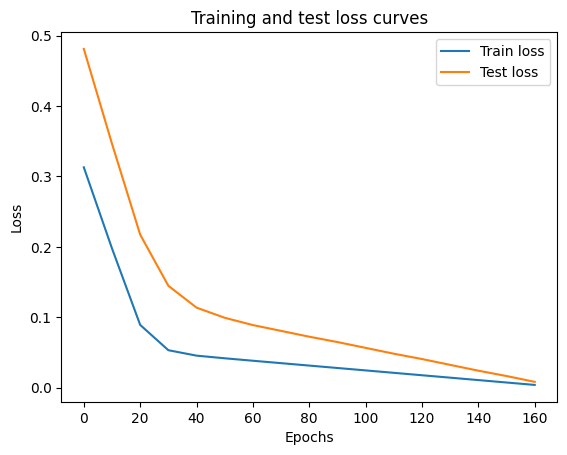

In [45]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [46]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [47]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [48]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = LinearRegressionModel()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [49]:
# 1. Put the loaded model into evaluation mode
loaded_model_0.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test) # perform a forward pass on the test data with the loaded model


In [5]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [6]:
# Subclass nn.Module to make our model
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear() for creating the model parameters
        self.linear_layer = nn.Linear(in_features=1,
                                      out_features=1)

    # Define the forward computation (input data x flows through nn.Linear())
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

# Set the manual seed when creating the model (this isn't always needed but is used for demonstrative purposes, try commenting it out and seeing what happens)
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [7]:
# Set model to GPU if it's available, otherwise it'll default to CPU
model_1.to(device) # the device variable was set above to be "cuda" if available or "cpu" if not
next(model_1.parameters()).device

device(type='cuda', index=0)

In [8]:
# Create loss function
loss_fn = nn.L1Loss()

# Create optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), # optimize newly created model's parameters
                            lr=0.01)
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data on the available device
# Without this, error will happen (not all model/data on device)
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_1.train() # train mode is on by default after construction

    # 1. Forward pass
    y_pred = model_1(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad optimizer
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    ### Testing
    model_1.eval() # put the model in evaluation mode for testing (inference)
    # 1. Forward pass
    with torch.inference_mode():
        test_pred = model_1(X_test)

        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Train loss: 0.5551779866218567 | Test loss: 0.5739762187004089
Epoch: 100 | Train loss: 0.006215683650225401 | Test loss: 0.014086711220443249
Epoch: 200 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 300 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 400 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 500 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 600 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 700 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 800 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 900 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882


In [9]:
# Find our model's learned parameters
from pprint import pprint # pprint = pretty print, see: https://docs.python.org/3/library/pprint.html
print("The model learned the following values for weights and bias:")
pprint(model_1.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


In [11]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
    y_preds = model_1(X_test)
y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

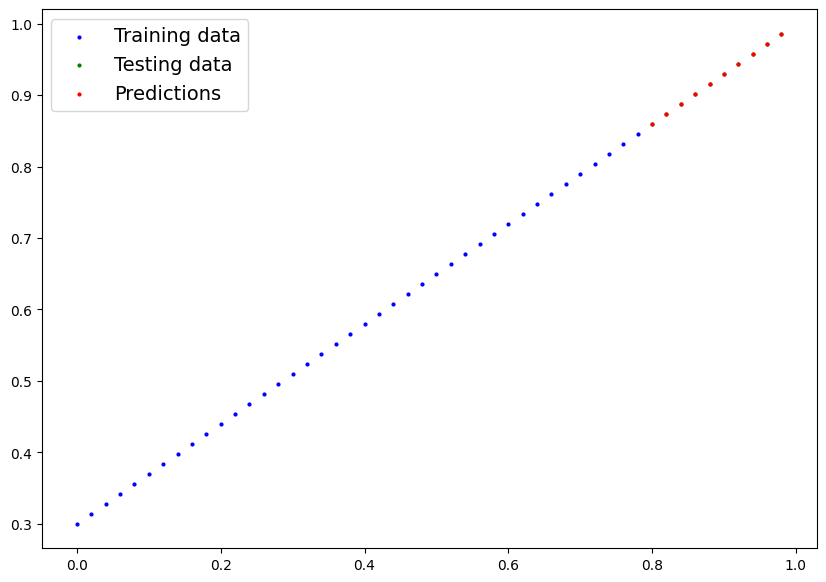

In [12]:
# Put data on the CPU and plot it
plot_predictions(predictions=y_preds.cpu())

In [13]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


##Exercises

In [1]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [3]:
# Create *known* parameters
weight = 0.3
bias = 0.9

# Create data
start = 0
end = 2
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.9000],
         [0.9060],
         [0.9120],
         [0.9180],
         [0.9240],
         [0.9300],
         [0.9360],
         [0.9420],
         [0.9480],
         [0.9540]]))

In [4]:
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(80, 80, 20, 20)

In [5]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

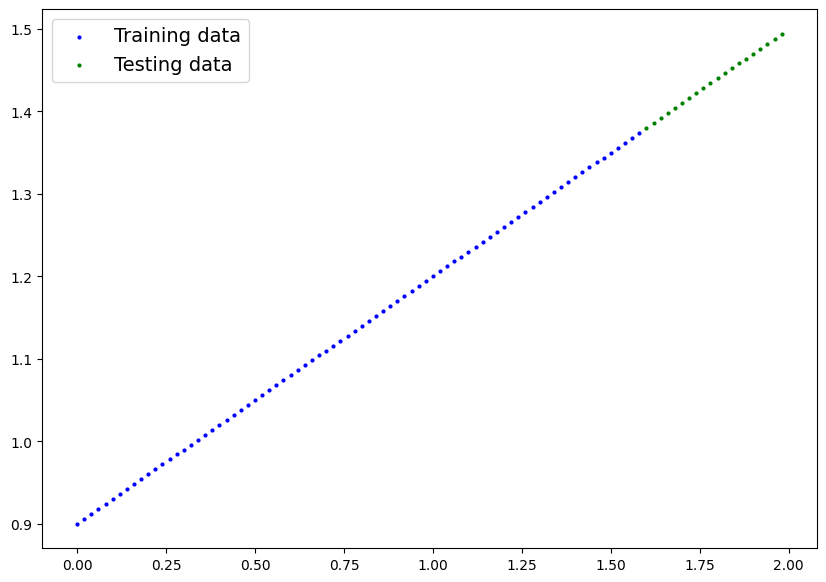

In [6]:
plot_predictions()

In [7]:
# Subclass nn.Module to make our model
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear() for creating the model parameters
        self.linear_layer = nn.Linear(in_features=1,
                                      out_features=1)

    # Define the forward computation (input data x flows through nn.Linear())
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

# Set the manual seed when creating the model (this isn't always needed but is used for demonstrative purposes, try commenting it out and seeing what happens)
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [8]:
# Set model to GPU if it's available, otherwise it'll default to CPU
model_1.to(device) # the device variable was set above to be "cuda" if available or "cpu" if not
next(model_1.parameters()).device

device(type='cpu')

In [9]:
torch.manual_seed(42)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 300

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

# Create the loss function
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss

# Create the optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), # parameters of target model to optimize
                            lr=0.01) # learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time))

if device != "cpu":
  # Send data to target device
  X_train = X_train.to(device)
  X_test = X_test.to(device)
  y_train = y_train.to(device)
  y_test = y_test.to(device)

for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model)
    model_1.train()

    # 1. Forward pass on train data using the forward() method inside
    y_pred = model_1(X_train)
    # print(y_pred)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    ### Testing

    # Put the model in evaluation mode
    model_1.eval()

    with torch.inference_mode():
      # 1. Forward pass on test data
      test_pred = model_1(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

      # Print out what's happening
      if epoch % 20 == 0:
        # Put model in evaluation mode and setup inference context
        model_1.eval()
        with torch.inference_mode():
          # 1. Forward pass
          y_preds = model_1(X_test)
          # 2. Calculate test loss
          test_loss = loss_fn(y_preds,y_test)
          # Print out what's happening
          print(f"Epoch: {epoch} | Train loss: {loss:.3f} | Test loss: {test_loss:.3f}")

Epoch: 0 | Train loss: 0.304 | Test loss: 0.740
Epoch: 20 | Train loss: 0.140 | Test loss: 0.384
Epoch: 40 | Train loss: 0.093 | Test loss: 0.210
Epoch: 60 | Train loss: 0.074 | Test loss: 0.148
Epoch: 80 | Train loss: 0.055 | Test loss: 0.108
Epoch: 100 | Train loss: 0.037 | Test loss: 0.072
Epoch: 120 | Train loss: 0.019 | Test loss: 0.036
Epoch: 140 | Train loss: 0.005 | Test loss: 0.020
Epoch: 160 | Train loss: 0.005 | Test loss: 0.020
Epoch: 180 | Train loss: 0.005 | Test loss: 0.020
Epoch: 200 | Train loss: 0.005 | Test loss: 0.020
Epoch: 220 | Train loss: 0.005 | Test loss: 0.020
Epoch: 240 | Train loss: 0.005 | Test loss: 0.020
Epoch: 260 | Train loss: 0.005 | Test loss: 0.020
Epoch: 280 | Train loss: 0.005 | Test loss: 0.020


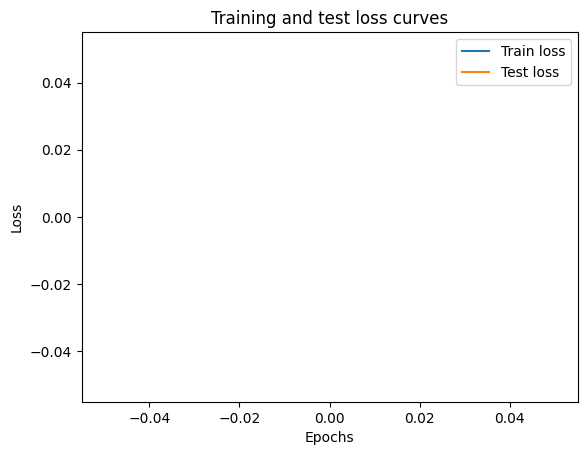

In [13]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [11]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
    y_preds = model_1(X_test)
y_preds

tensor([[1.3755],
        [1.3815],
        [1.3875],
        [1.3935],
        [1.3995],
        [1.4055],
        [1.4115],
        [1.4175],
        [1.4235],
        [1.4295],
        [1.4355],
        [1.4415],
        [1.4475],
        [1.4535],
        [1.4595],
        [1.4655],
        [1.4715],
        [1.4775],
        [1.4835],
        [1.4895]])

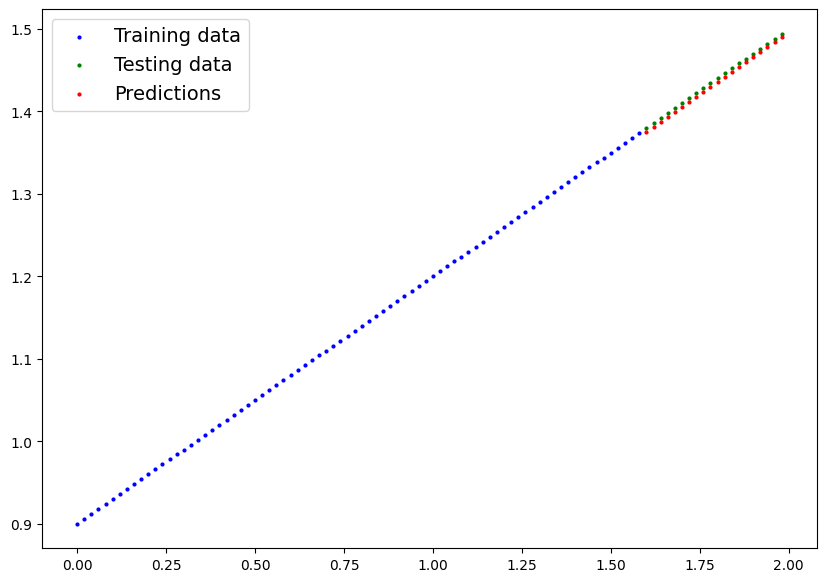

In [12]:
# Put data on the CPU and plot it
if device == "cpu":
  plot_predictions(predictions=y_preds)
else:
  plot_predictions(predictions=y_preds.cpu())